In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import datetime
from datetime import date
from datetime import timedelta
from datetime import datetime

In [2]:
#ENTER DATA HERE
machine_specs = {'TH':[95,68,66,72,90,93,100,90,100,90,88], 
                 'Elec':[.061,.055,.055,.05,.059,.059,.059,.059,.059,.059,.0575], 
                 'KW':[3.05,3.25,3.05,3.312,3.42,3.25,3.25,3.25,3.25,3.25,3.344], 
                 'Cost':[5568,3700,4100,4750,3800,3553,4329,3174,5000,4200,5000]}
specs_df = pd.DataFrame(data=machine_specs)

scenarios = {'Hashrate Change':[.05,.04,.03,.03,.02,.01,0,-.01,-.01,-.02],
             'Price Change':[.05,.05,.03,.01,.03,.02,0,.02,-.02,-.025]}
scenarios_df = pd.DataFrame(data=scenarios)

total_investment = 5000000

print(specs_df)

     TH    Elec     KW  Cost
0    95  0.0610  3.050  5568
1    68  0.0550  3.250  3700
2    66  0.0550  3.050  4100
3    72  0.0500  3.312  4750
4    90  0.0590  3.420  3800
5    93  0.0590  3.250  3553
6   100  0.0590  3.250  4329
7    90  0.0590  3.250  3174
8   100  0.0590  3.250  5000
9    90  0.0590  3.250  4200
10   88  0.0575  3.344  5000


In [3]:
class mining:
    def __init__(self, hash_change, price_change, th, elec, kw, cost, investment):
        self.monthly_hash_inc = hash_change
        self.monthly_price_inc = price_change
        self.investment = investment
        self.TH = th
        self.elec = elec
        self.kw = kw
        self.cost = cost
        self.investment = investment
        #Machine Specs Calculations
        num_machines = int(self.investment/self.cost)
        self.investment = num_machines*self.cost
        daily_costs = self.elec*self.kw*24*num_machines
        frim_hash = num_machines*self.TH
        start_net = 90000000
        start_price =32000
        monthly_hash_inc = self.monthly_hash_inc
        monthly_price_inc = self.monthly_price_inc
        transaction_fees = .0502 
        

        dates= []
        hashrate = []
        price = []
        sdate = datetime.today()   # start date
        self.sdate = sdate
        edate = datetime(2024, 3, 26)   # end date

        delta = edate - sdate # as timedelta
        intdelta = delta.days

        #List of each day
        for i in range(delta.days + 1):
            day = sdate + timedelta(days=i)
            dates.append(day)


        #Solve for average daily hash increase
        one_year_hash = start_net*((1+(monthly_hash_inc))**(12))
        yearly_hash_inc = (one_year_hash/start_net)-1
        daily_hash_inc = ((one_year_hash/start_net)**(1/365))-1

        temp = start_net
        for i in range(intdelta + 1):
            hashrate.append(temp)
            temp = temp*(1+daily_hash_inc)


        #Solve for average daily price increase
        one_year_price = start_price*((1+(monthly_price_inc))**(12))
        yearly_price_inc = (one_year_price/start_price)-1
        daily_price_inc = ((one_year_price/start_price)**(1/365))-1

        temp = start_price
        for i in range(intdelta + 1):
            price.append(temp)
            temp = temp*(1+daily_price_inc)


        #Put lists into dataframe and solve for other varibles
        df = pd.DataFrame(list(zip(dates, hashrate, price)), columns=['Date', 'Net Hashrate', 'BTC Price'])
        df = df.set_index(['Date'])

        df['Daily BTC Mined'] = (frim_hash/df['Net Hashrate'])*900
        df['Transaction Fees BTC'] = df['Daily BTC Mined']*transaction_fees
        df['Energy cost BTC'] = daily_costs/df['BTC Price'] 
        df['Daily BTC Profit'] = df['Transaction Fees BTC'] + df['Daily BTC Mined'] - df['Energy cost BTC']
        df['Cumulative BTC'] = df['Daily BTC Profit'].cumsum()
        df['Daily Revenue'] = df['Daily BTC Profit'].mul(df['BTC Price'])
        df['Cumulative Revenue'] = df['Daily Revenue'].cumsum()
        self.df = df 
        
        #Find breakeven date
        breakeven_date = self.df.loc[self.df['Cumulative Revenue']>=self.investment].index[0] if self.df['Cumulative Revenue'].iloc[-1] > self.investment else self.sdate
        self.breakeven_days = breakeven_date - self.sdate

        #Find ROI
        total_revenue = self.df['Cumulative Revenue'].iloc[-1]
        self.roi = ((total_revenue-self.investment)/self.investment)*100
        
    def ROI(self):
        #Find breakeven date
        breakeven_date = self.df.loc[self.df['Cumulative Revenue']>=self.investment].index[0] if self.df['Cumulative Revenue'].iloc[-1] > self.investment else self.sdate
        self.breakeven_days = breakeven_date - self.sdate
        print('It will take ' + str(self.breakeven_days.days) + ' days to breakeven')

        #Find ROI
        total_revenue = self.df['Cumulative Revenue'].iloc[-1]
        roi = ((total_revenue-self.investment)/self.investment)*100
        print('The return on investment for this scenario is ' + str(round(self.roi)) + '%')
        
    def total(self):
        print('Total BTC: '+ str(self.df['Cumulative BTC'].iloc[-1]))
        print('Total USD: '+ str(self.df['Cumulative Revenue'].iloc[-1]))
        print(' ')

In [4]:
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        globals()['machine{}_scenario{}'.format(x,y)]= mining(scenarios_df['Hashrate Change'][y],
                                               scenarios_df['Price Change'][y],
                                               specs_df['TH'][x],
                                               specs_df['Elec'][x],
                                               specs_df['KW'][x],
                                               specs_df['Cost'][x],
                                               total_investment)
machine0_scenario0.df.head()

,Net Hashrate,BTC Price,Daily BTC Mined,Transaction Fees BTC,Energy cost BTC,Daily BTC Profit,Cumulative BTC,Daily Revenue,Cumulative Revenue
Date,,,,,,,,,
2021-07-29 19:35:41.412379,9.000000e+07,32000.000000,0.852150,0.042778,0.125165,0.769763,0.769763,24632.40936,24632.40936
2021-07-30 19:35:41.412379,9.014448e+07,32051.371116,0.850784,0.042709,0.124965,0.768529,1.538292,24632.40936,49264.81872
2021-07-31 19:35:41.412379,9.028919e+07,32102.824701,0.849421,0.042641,0.124764,0.767297,2.305589,24632.40936,73897.22808
2021-08-01 19:35:41.412379,9.043414e+07,32154.360887,0.848059,0.042573,0.124564,0.766067,3.071657,24632.40936,98529.63744
2021-08-02 19:35:41.412379,9.057932e+07,32205.979806,0.846700,0.042504,0.124365,0.764840,3.836496,24632.40936,123162.04680


In [5]:
#Test Different Functions of the Class
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        globals()['machine{}_scenario{}'.format(x,y)].ROI()

It will take 202 days to breakeven
The return on investment for this scenario is 379%
It will take 195 days to breakeven
The return on investment for this scenario is 473%
It will take 202 days to breakeven
The return on investment for this scenario is 379%
It will take 219 days to breakeven
The return on investment for this scenario is 236%
It will take 195 days to breakeven
The return on investment for this scenario is 475%
It will take 195 days to breakeven
The return on investment for this scenario is 476%
It will take 202 days to breakeven
The return on investment for this scenario is 379%
It will take 182 days to breakeven
The return on investment for this scenario is 753%
It will take 211 days to breakeven
The return on investment for this scenario is 298%
It will take 206 days to breakeven
The return on investment for this scenario is 336%
It will take 199 days to breakeven
The return on investment for this scenario is 387%
It will take 192 days to breakeven
The return on inves

In [6]:
#Format results into a dataframe
name=[]
BTC=[]
Revenue=[]
breakeven=[]
roi=[]
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        name.append('machine{}_scenario{}'.format(x,y))
        BTC.append(globals()['machine{}_scenario{}'.format(x,y)].df['Cumulative BTC'].iloc[-1])
        Revenue.append(format(globals()['machine{}_scenario{}'.format(x,y)].df['Cumulative Revenue'].iloc[-1],'.2f'))
        breakeven.append(globals()['machine{}_scenario{}'.format(x,y)].breakeven_days)
        roi.append(globals()['machine{}_scenario{}'.format(x,y)].roi)
        
        
results = pd.DataFrame(list(zip(name, BTC, Revenue, breakeven, roi)), columns=['Scenario', 'BTC', 'Revenue', 'Days to Breakeven', 'ROI %'])
results.head(110)

,Scenario,BTC,Revenue,Days to Breakeven,ROI %
0,machine0_scenario0,379.098807,23918069.49,202 days,378.888550
1,machine0_scenario1,434.279181,28628007.89,195 days,473.191127
2,machine0_scenario2,484.036946,23918069.49,202 days,378.888550
3,machine0_scenario3,458.601432,16785498.70,219 days,236.079931
4,machine0_scenario4,565.587558,28729956.97,195 days,475.232355
...,...,...,...,...,...
105,machine10_scenario5,665.118697,29258617.12,193 days,485.172342
106,machine10_scenario6,757.346986,24235103.55,200 days,384.702071
107,machine10_scenario7,954.048806,43510707.18,180 days,770.214144
108,machine10_scenario8,861.255766,20050299.74,208 days,301.005995


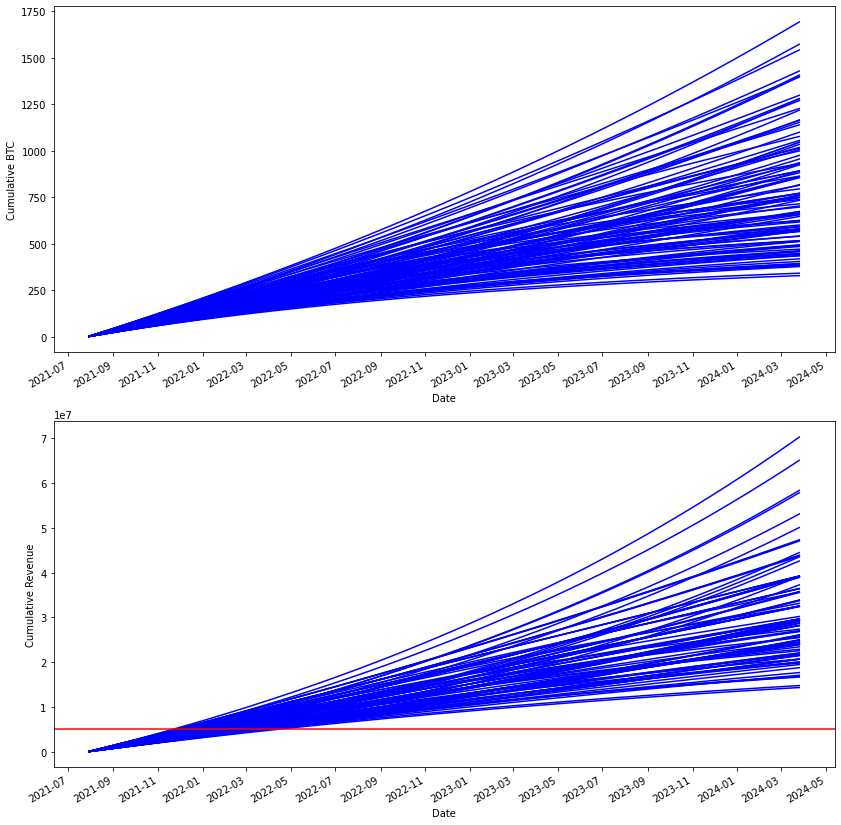

In [7]:
#Visualize revenue 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,14))

ax1.set_ylabel('Cumulative BTC')
ax1.set_xlabel('Date')
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        ax1.plot(globals()['machine{}_scenario{}'.format(x,y)].df['Cumulative BTC'], color = 'blue')
fmt_half_year = mdates.MonthLocator(interval=2)
ax1.xaxis.set_major_locator(fmt_half_year)
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right')

ax2.set_ylabel('Cumulative Revenue')
ax2.set_xlabel('Date')
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        ax2.plot(globals()['machine{}_scenario{}'.format(x,y)].df['Cumulative Revenue'], color = 'blue')
plt.setp(ax2.get_xticklabels(), rotation=30, ha='right')
ax2.xaxis.set_major_locator(fmt_half_year)
plt.axhline(y=machine0_scenario0.investment, color='r', linestyle='-')

In [ ]:
d={}
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        d['machine{}_scenario{}'.format(x,y)]= mining(scenarios_df['Hashrate Change'][y],
                                               scenarios_df['Price Change'][y],
                                               specs_df['TH'][x],
                                               specs_df['Elec'][x],
                                               specs_df['KW'][x],
                                               specs_df['Cost'][x],
                                               total_investment)

for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        d['machine{}_scenario{}'.format(x,y)]

for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        d['machine{}_scenario{}'.format(x,y)].ROI()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,14))

ax1.set_ylabel('Cumulative BTC')
ax1.set_xlabel('Date')
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        ax1.plot(d['machine{}_scenario{}'.format(x,y)].df['Cumulative BTC'], color = 'blue')
fmt_half_year = mdates.MonthLocator(interval=2)
ax1.xaxis.set_major_locator(fmt_half_year)
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right')

ax2.set_ylabel('Cumulative Revenue')
ax2.set_xlabel('Date')
for x in range(len(specs_df)):
    for y in range(len(scenarios_df)):
        ax2.plot(d['machine{}_scenario{}'.format(x,y)].df['Cumulative Revenue'], color = 'blue')
plt.setp(ax2.get_xticklabels(), rotation=30, ha='right')
ax2.xaxis.set_major_locator(fmt_half_year)
plt.axhline(y=d[machine0_scenario0].investment, color='r', linestyle='-')

In [ ]:
d[machine1_scenario1].ROI()